## Operationalizing the Machine Learning Development Life Cycle

### Introduction: Home Loan Approval Prediction Model
### Story Board
### Banks are getting thousand of home loan applications every day. Manually evaluating each of application through bank employees is time consuming and involve human bias
### CustomerA of ACME Financials connects to their web site to request a new home loan. He/she inputs the required information and apply for the loan. The system returns the approval status within seconds
### Data Scientists at ACME Financials are monitoring the effectiveness of the home loan prediction model and detect some data drift.
### Data Scientists retrain and update the model to provide better prediction
### The new model is released and deployed to production
### Another Customer B (with similar profile as Customer A) apply for a home loan and the approval status is returned within seconds using the new model


#### Conda Env : General Machine Learning p38 cpu V1

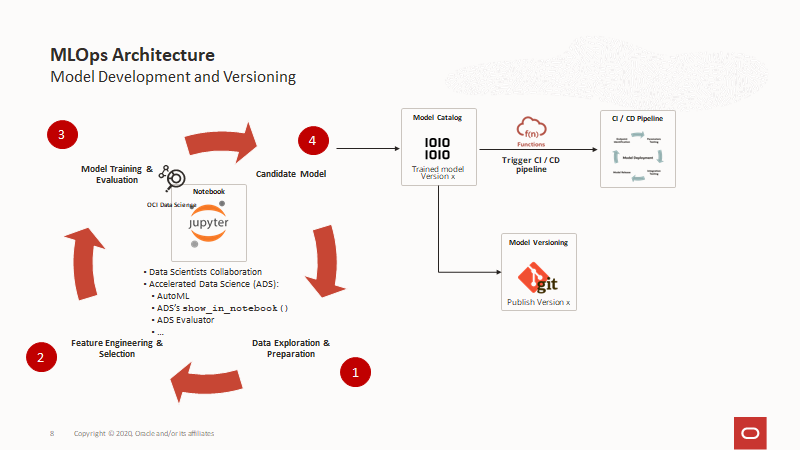

### Prerequisites

This notebook requires authorization to work with the OCI Data Science Service. Details can be found [here](https://accelerated-data-science.readthedocs.io/en/latest/user_guide/cli/authentication.html#). For the purposes of this notebook what is important to to know is that resource principals will be used absent api_key authentication.

---

Datasets are provided as a convenience. Datasets are considered third-party content and are not considered materials under your agreement with Oracle.
      

# Load libraries

In [1]:
import ads
import logging
import os
import tempfile
import warnings
import pandas as pd
import numpy as np
from ads.common.model_metadata import UseCaseType
from ads.model.framework.sklearn_model import SklearnModel
from ads.dataset.factory import DatasetFactory
from shutil import rmtree
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from category_encoders.ordinal import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

logging.basicConfig(format="%(levelname)s:%(message)s", level=logging.ERROR)
warnings.filterwarnings("ignore")

## Authenticate

Authentication to the OCI Data Science service is required. Here we default to resource principals.

In [2]:
ads.set_auth(auth="resource_principal")

# Reading Data from LakeHouse

In [3]:
#Read the data from Lake House
#bucket_name = "mlopsdemobucket"
#namespace = "apaccpt01"
#file_name = "CREDIT_SCORING_v2.csv"
#storage_options = {'config': {'tenancy': os.environ['TENANCY_OCID'], 'region': os.environ['NB_REGION']}}
#ds = pd.read_csv(f"oci://{bucket_name}@{namespace}/{file_name}")

# Read data from local drive
ds = pd.read_csv(f"/home/datascience/df.csv")

ds.head()

,MARITAL_STATUS,EDUCATION_LEVEL,RESIDENTAL_STATUS,LOAN_AMOUNT,INCOME,GENDER,NUMBER_OF_PRIOR_LOANS,AGE,TENURE,PRESENT_EMPLOYMENT_SINCE,FAMILY_SIZE,OCCUPATION,Home_Loan_Approval_Prediction
0,Single,Primary School Grad,NaN,35000.0,500.0,Male,1.0,34.0,57.0,Less Than Seven Years,4.0,Worker,0
1,Divorced,Master's Degree,Tenant,20000.0,2750.0,Female,3.0,67.0,1.0,More Than Seven Years,2.0,Manager,0
2,Single,Primary School Grad,Family Home,100000.0,500.0,Male,3.0,31.0,39.0,Less Than Four Years,3.0,Clerical,0
3,Single,Bachelor's Degree,Owner,25000.0,6250.0,Female,2.0,56.0,36.0,Unemployed,2.0,Manager,1
4,Married,Bachelor's Degree,Tenant,30000.0,2750.0,Female,3.0,47.0,6.0,Less Than Seven Years,4.0,Worker,0


In [4]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MARITAL_STATUS                 4938 non-null   object 
 1   EDUCATION_LEVEL                4927 non-null   object 
 2   RESIDENTAL_STATUS              4949 non-null   object 
 3   LOAN_AMOUNT                    4943 non-null   float64
 4   INCOME                         4941 non-null   float64
 5   GENDER                         4941 non-null   object 
 6   NUMBER_OF_PRIOR_LOANS          4950 non-null   float64
 7   AGE                            4950 non-null   float64
 8   TENURE                         4945 non-null   float64
 9   PRESENT_EMPLOYMENT_SINCE       4931 non-null   object 
 10  FAMILY_SIZE                    4953 non-null   float64
 11  OCCUPATION                     4941 non-null   object 
 12  Home_Loan_Approval_Prediction  5000 non-null   i

# ADS : Automated Data Quality Check
# let's ask the ADS to provide us some recommendations

In [5]:
df = DatasetFactory.from_dataframe(ds, target="Home_Loan_Approval_Prediction")

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
print('suggest_recommendations ...')
suggestion_df = df.suggest_recommendations()
suggestion_df

suggest_recommendations ...


Code
Message                     Variables                     Suggested                         Action                                                                                                                       
Contains missing values(62) MARITAL_STATUS                Fill missing values with frequent Drop                                                                                        .drop_columns(["MARITAL_STATUS"])
                                                                                            Fill missing values with frequent                                                      .fillna({"MARITAL_STATUS": "Married"})
                                                                                            Fill missing values with constant                                                     .fillna({"MARITAL_STATUS": "constant"})
                                                                                            Do nothing                                                                                                                   
Contains missing values(73) EDUCATION_LEVEL               Fill missing values with frequent Drop                                                                                       .drop_columns(["EDUCATION_LEVEL"])
                                                                                            Fill missing values with frequent                                           .fillna({"EDUCATION_LEVEL": "Bachelor's Degree"})
                                                                                            Fill missing values with constant                                                    .fillna({"EDUCATION_LEVEL": "constant"})
                                                                                            Do nothing                                                                                                                   
Contains missing values(51) RESIDENTAL_STATUS             Fill missing values with frequent Drop                                                                                     .drop_columns(["RESIDENTAL_STATUS"])
                                                                                            Fill missing values with frequent                                                    .fillna({"RESIDENTAL_STATUS": "Tenant"})
                                                                                            Fill missing values with constant                                                  .fillna({"RESIDENTAL_STATUS": "constant"})
                                                                                            Do nothing                                                                                                                   
Contains missing values(57) LOAN_AMOUNT                   Fill missing values with frequent Drop                                                                                           .drop_columns(["LOAN_AMOUNT"])
                                                                                            Fill missing values with frequent                                                           .fillna({"LOAN_AMOUNT": 20000.0})
                                                                                            Fill missing values with constant                                                        .fillna({"LOAN_AMOUNT": "constant"})
                                                                                            Do nothing                                                                                                                   
Contains missing values(59) INCOME                        Fill missing values with frequent Drop                                                                                                .drop_columns(["INCOME"])
                                                                       

In [7]:
# Treat Missing Value
df.fillna({"MARITAL_STATUS": "Married"})

Home_Loan_Approval_Prediction,MARITAL_STATUS,EDUCATION_LEVEL,RESIDENTAL_STATUS,LOAN_AMOUNT,INCOME,GENDER,NUMBER_OF_PRIOR_LOANS,AGE,TENURE,PRESENT_EMPLOYMENT_SINCE,FAMILY_SIZE,OCCUPATION
0,Single,Primary School Grad,nan,35000.000000,500.000000,Male,1.000000,34.000000,57.000000,Less Than Seven Years,4.000000,Worker
0,Divorced,Master's Degree,Tenant,20000.000000,2750.000000,Female,3.000000,67.000000,1.000000,More Than Seven Years,2.000000,Manager
0,Single,Primary School Grad,Family Home,100000.000000,500.000000,Male,3.000000,31.000000,39.000000,Less Than Four Years,3.000000,Clerical
1,Single,Bachelor's Degree,Owner,25000.000000,6250.000000,Female,2.000000,56.000000,36.000000,Unemployed,2.000000,Manager
0,Married,Bachelor's Degree,Tenant,30000.000000,2750.000000,Female,3.000000,47.000000,6.000000,Less Than Seven Years,4.000000,Worker


BinaryClassificationDataset(target: Home_Loan_Approval_Prediction) 5,000 rows, 13 columns

# ADS : Automated data profiling and preparation
## Data Exploration & Preparation
### Performing Data Visualization

In [8]:
df.show_in_notebook()

Accordion(children=(HTML(value='<h1>Name: User Provided DataFrame</h1><h3>Type: BinaryClassificationDataset</h…

# ADS : Automated Feature Engineering & Data Transformation

In [9]:
transformed_ds = df.auto_transform(fix_imbalance=False)

loop1:   0%|          | 0/7 [00:00<?, ?it/s]

# Data Partition
## Split data in to two part : training & testing datasets

In [10]:
train, test = transformed_ds.train_test_split(test_size=0.9)

In [11]:
%%writefile dataframelabelencoder.py 

from category_encoders.ordinal import OrdinalEncoder
from collections import defaultdict

from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

class DataFrameLabelEncoder(TransformerMixin):
    def __init__(self):
        self.label_encoders = defaultdict(LabelEncoder)
        
    def fit(self, X):
        for column in X.columns:
            if X[column].dtype.name  in ["object", "category"]:
                self.label_encoders[column] = OrdinalEncoder()
                self.label_encoders[column].fit(X[column])
        return self
    
    def transform(self, X):
        for column, label_encoder in self.label_encoders.items():
            X[column] = label_encoder.transform(X[column])
        return X

Overwriting dataframelabelencoder.py


# ADS : Automated machine learning (Oracle AutoML)
## Model Training & Evaluation

In [12]:
from dataframelabelencoder import DataFrameLabelEncoder

In [13]:
X = train.X.copy()
y = train.y.copy()

le = DataFrameLabelEncoder()
X = le.fit_transform(X)

sk_clf = RandomForestClassifier(random_state=0, max_depth = 7)
sk_clf.fit(X, y)

sk_model = make_pipeline(le, sk_clf)

# Build an ads model from the SVM classifier
#my_model = ADSModel.from_estimator(sk_model, name=sk_clf.__class__.__name__)

## Prepare the model

In [14]:
artifact_dir = tempfile.mkdtemp()
sklearn_model = SklearnModel(estimator=sk_model, artifact_dir=artifact_dir)
sklearn_model.prepare(
    inference_conda_env="generalml_p38_cpu_v1",
    training_conda_env="generalml_p38_cpu_v1",
    use_case_type=UseCaseType.BINARY_CLASSIFICATION,
    X_sample=X,
    y_sample=y,
    force_overwrite=True,
)

algorithm: Pipeline
artifact_dir:
  /tmp/tmp6mgfmhbg:
  - - runtime.yaml
    - score.py
    - input_schema.json
    - output_schema.json
    - model.joblib
framework: scikit-learn
model_deployment_id: null
model_id: null

In [15]:
#setting paths for artifact files that need to be modified: 
encoder_path = os.path.join(artifact_dir, "dataframelabelencoder.py")
score_path = os.path.join(artifact_dir, "score.py")
!cp dataframelabelencoder.py {encoder_path}

In [16]:
%%writefile {score_path}

"""
   Inference script. This script is used for prediction by scoring server when schema is known.
"""

import json
import os
from joblib import load
import io 
import pandas as pd
import logging 

# logging configuration - OPTIONAL 
logging.basicConfig(format='%(name)s - %(levelname)s - %(message)s', level=logging.INFO)
logger_pred = logging.getLogger('model-prediction')
logger_pred.setLevel(logging.INFO)
logger_feat = logging.getLogger('input-features')
logger_feat.setLevel(logging.INFO)

from dataframelabelencoder import DataFrameLabelEncoder

def load_model():
    """
    Loads model from the serialized format

    Returns
    -------
    model:  a model instance on which predict API can be invoked
    """
    model_dir = os.path.dirname(os.path.realpath(__file__))
    contents = os.listdir(model_dir)
    model_file_name = "model.joblib"
    # TODO: Load the model from the model_dir using the appropriate loader
    # Below is a sample code to load a model file using `cloudpickle` which was serialized using `cloudpickle`
    # from cloudpickle import cloudpickle
    if model_file_name in contents:
        with open(os.path.join(os.path.dirname(os.path.realpath(__file__)), model_file_name), "rb") as file:
            model = load(file) # Use the loader corresponding to your model file.
    else:
        raise Exception('{0} is not found in model directory {1}'.format(model_file_name, model_dir))
    
    return model


def predict(data, model=load_model()) -> dict:
    """
    Returns prediction given the model and data to predict

    Parameters
    ----------
    model: Model instance returned by load_model API
    data: Data format as expected by the predict API of the core estimator. For eg. in case of sckit models it could be numpy array/List of list/Panda DataFrame

    Returns
    -------
    predictions: Output from scoring server
        Format: { 'prediction': output from `model.predict` method }

    """
    assert model is not None, "Model is not loaded"
    X = pd.read_json(io.StringIO(data)) if isinstance(data, str) else pd.DataFrame.from_dict(data)
    preds = model.predict(X).tolist()
    #logger_pred.info(preds)
    #logger_feat.info(X)    
    return { 'prediction': preds }

Overwriting /tmp/tmp6mgfmhbg/score.py


In [17]:
sklearn_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Done          Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Available     Local tested .predict from score.py                               
save()    Available     Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  Not Available Deployed the model                                                
predict() Not Available Called deployment predict endpoint

## Verify

The verify method invokes the ``predict`` function defined inside ``score.py`` in the artifact_dir

## Save

In [18]:
sklearn_model.save(display_name="MLOPS_BANK_V1")

['runtime.yaml', 'score.py', 'dataframelabelencoder.py', 'input_schema.json', 'output_schema.json', 'model.joblib']


loop1:   0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
sklearn_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Done          Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Available     Local tested .predict from score.py                               
save()    Done          Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  Available     Deployed the model                                                
predict() Not Available Called deployment predict endpoint

## Deploy

When the model is in the model catalog, you can use the model's `.deploy()` method to deploy it. This method allows you to specify the attributes of the deployment such as the display name, description, instance type and count, the maximum bandwidth, and logging groups. The next cell deploys the model with the default settings except for the custom display name. The `.deploy()` method returns a `ModelDeployment` object.

In [20]:
deploy = sklearn_model.deploy(
    display_name="MLOPS_BANK_V1",
)

loop1:   0%|          | 0/6 [00:00<?, ?it/s]

In [21]:
sklearn_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Done          Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Available     Local tested .predict from score.py                               
save()    Done          Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  CREATING      Deployed the model                                                
predict() Not Available Called deployment predict endpoint